In [1]:
import datetime
import os, sys
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import librosa
import scipy


sys.path.append('src')
PATCH_HOP_SECONDS = 0.25
from models.get_models import get_model
import models.yamnet_tf2.params as params
params = params.Params(sample_rate=16000, patch_hop_seconds=PATCH_HOP_SECONDS)

# Declare model
training_path = "./training/20220419-215928"
MODEL_NAME = "YAMNET"
DENSE_UNITS=640
model = get_model(MODEL_NAME, dense_units = DENSE_UNITS)
# model.summary()
model_training_path = training_path + "/{}".format(MODEL_NAME)
ckp_path = model_training_path + "/checkpoints/cp.ckpt"

# Evaluate performance of model with test fold (that it wasn't trained on)
model.load_weights(ckp_path)

DATASET_DIR = "./datasets/cer_dataset_16k_resampled_split/"
import dataload_utils.data_load as data_load
dataset_loader = data_load.Dataset_loader(DATASET_DIR, params)
filenames_all = dataset_loader.__filenames_all__
classes = dataset_loader.__classes__
num_classes = dataset_loader.__num_classes__
print("classes: {}, num_classes: {}".format(classes, num_classes))

Number of files in Class_00_Modified_car_engines: 4644
Number of files in Class_01_Regular_Vehicles: 9539
Number of files in Class_02_Tools_and_Mechanisms: 13307
Number of files in Class_03_Environmental_Sounds: 10488
Number of files:  37978
classes: ['Class_00_Modified_car_engines', 'Class_01_Regular_Vehicles', 'Class_02_Tools_and_Mechanisms', 'Class_03_Environmental_Sounds'], num_classes: 4


In [2]:
import glob
import librosa
import matplotlib.pyplot as plt
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

def plot_filename(filename):
    wav, sr = librosa.load(filename, sr=16000)
    waveform = tf.cast(wav, dtype=tf.float32)

    spec, melspec = dataset_loader.get_embeddings_and_features_librosa(filename) 
    scores = np.array(model.predict(melspec))
    
    plt.figure(figsize=(10, 6))

    # Plot the waveform.
    plt.subplot(3, 1, 1)
    plt.plot(waveform)
    plt.xlim([0, len(waveform)])

    # Plot the log-mel spectrogram (returned by the model).
    plt.subplot(3, 1, 2)
    plt.imshow(spec.numpy().T, aspect='auto', interpolation='nearest', origin='lower')
    # print(np.max(spec.numpy()), np.min(spec.numpy()))

    # Plot and label the model output scores for the top-scoring classes.
    mean_scores = np.mean(scores, axis=0)
    # top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
    plt.subplot(3, 1, 3)
    # plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

    score_map = (scores[:, np.arange(num_classes)].T)
    max_score = np.argmax(score_map, axis=0)
    max_score_onehot = tf.one_hot(max_score,num_classes).numpy().T
    # score_map_top1 = np.zeros(score_map.shape)
    plt.imshow(score_map)
    plt.imshow(max_score_onehot,alpha=0.6)

    # patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
    # values from the model documentation
    patch_padding = (0.96 / 2) / PATCH_HOP_SECONDS
    plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
    # Label the top_N classes.
    yticks = range(0, num_classes, 1)
    plt.yticks(yticks,classes)
    _ = plt.ylim(-0.5 + np.array([num_classes, 0]))
    return max_score

FILENAME_ALL_LENGTH = len(filenames_all)

Predictions for each embedding: [3 3 3 3 1 1 3 3 3 3 3 1 1 1],     
Prediction Class name: Class_03_Environmental_Sounds 
Real Class and file name: ./datasets/cer_dataset_16k_resampled_split/Class_03_Environmental_Sounds\UrbanSounds8K_remaining\55018-0-0-248_000.wav


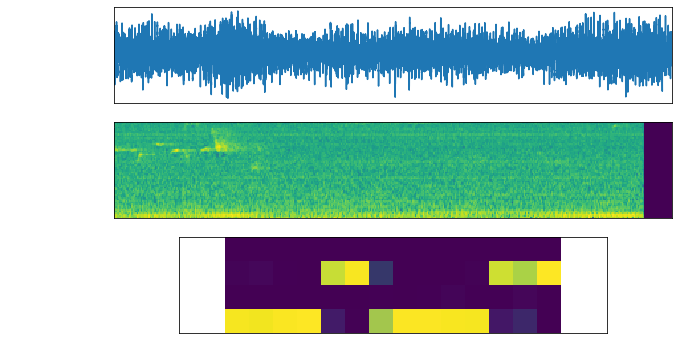

In [3]:
filename = filenames_all[random.randint(0,FILENAME_ALL_LENGTH)]
scores = plot_filename(filename)
most_scored = scipy.stats.mode(scores)
print("Predictions for each embedding: {}, \
    \nPrediction Class name: {} \nReal Class and file name: {}".format(
        scores, classes[most_scored.mode[0]], filename.split("resampled\\")[-1]
        ))

# os.system("python ./src/dataload_utils/play_sound.py -f {}".format(filename))

In [4]:
import glob
import librosa
import matplotlib.pyplot as plt
from tkinter import TclError
# to display in separate Tk window
%matplotlib tk

COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

try:
    # pass
    !del /S .\test_save_files\**"    
except:
    pass
    
first_loop_flag=True
save_file_path = "./test_save_files/"
# for i in range(10000):
while 1==1:
    try:
        filename = save_file_path + os.listdir(save_file_path)[-1]
        print("Processing file: {}".format(filename))
        wav, sr = librosa.load(filename, sr=16000)
        waveform = tf.cast(wav, dtype=tf.float32)
        spec, melspec = dataset_loader.get_embeddings_and_features_librosa(filename) 
        os.system("del /S {}".format(filename))
        scores = np.array(model.predict(melspec))
        
        if first_loop_flag==True:

            # fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 6))
            fig, ax = plt.subplots(3, figsize=(10, 6))
            ax=ax.flatten()
            
            wave_plot, = ax[0].plot(waveform)
            ax[0].axis(xmin=0,xmax=len(waveform), ymin=-1, ymax=1) #xlim([0, len(waveform)])

            spec_plot = ax[1].imshow(spec.numpy().T, aspect='auto', interpolation='nearest', origin='lower')
            score_map = (scores.T)
            max_score = np.argmax(score_map, axis=0)
            max_score_onehot = tf.one_hot(max_score,num_classes).numpy().T
            # score_map_top1 = np.zeros(score_map.shape)
            # ax3.imshow(score_map)
            # ASPECT = score_map.shape[1]/score_map.shape[0]
            # score_map = scipy.special.softmax(score_map, axis=1)
            # score_plot = ax[2].imshow(score_map, extent=[0,score_map.shape[1],0,score_map.shape[0]], aspect=5)
            # score_plot = ax[2].imshow(max_score_onehot)
            score_plot = ax[2].imshow(score_map)
            # ASPECT = int(score_map.shape[0]/score_map.shape[1])
            # score_plot = ax[2].imshow(
            #     score_map, extent=[0,score_map.shape[0],0,score_map.shape[1]], 
            #     aspect=ASPECT
            #     )
            # patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
            # values from the model documentation
            # patch_padding = 0
            patch_padding = (0.96 / 2) / PATCH_HOP_SECONDS
            ax[2].axis(xmin=-patch_padding-0.5,xmax=score_map.shape[1] + patch_padding-0.5) # xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
            # Label the top_N classes.
            yticks=np.arange(num_classes)
            ax[2].set_yticks(yticks, classes)
            _ = ax[2].axis(ymax=-0.5, ymin=num_classes-0.5) #.()ylim
            # _ = ax[2].axis(ymax=-0.5, ymin=-0.5 + top_n) #.()ylim
            first_loop_flag=False

        # Plot the waveform.
        wave_plot.set_ydata(waveform)
        # Plot the log-mel spectrogram (returned by the model).
        spec_plot.set_data(spec.numpy().T)
        spec_plot.set_clim(-4, 4)
        # Plot and label the model output scores for the top-scoring classes.
        score_map = (scores.T)
        max_score = np.argmax(score_map, axis=0)
        max_score_onehot = tf.one_hot(max_score,num_classes).numpy().T
        # score_map_top1 = np.zeros(score_map.shape)
        # plt.imshow(score_map)
        # score_plot.set_data(score_map)# ,alpha=0.6)
        score_plot.set_data(score_map)# ,alpha=0.6)
        # score_plot.set_data(max_score_onehot)# ,alpha=0.6)
        # score_plot.set_xlabel("Most Recent Prediction: {}".format(classes[np.argmax(max_score_onehot[:,-1])]))
                # score_plot.set_alpha(0.6)
        # score_plot.set_data(max_score_onehot)# ,alpha=0.6)
        fig.canvas.draw()
        fig.canvas.flush_events()

    except:
        print("Error")

Deleted file - c:\Users\User\Documents\comparing_acoustic_deep_neural_networks\test_save_files\output_2022-04-20_12-39-54-108814.wav
Deleted file - c:\Users\User\Documents\comparing_acoustic_deep_neural_networks\test_save_files\output_2022-04-20_12-39-55-088923.wav
Deleted file - c:\Users\User\Documents\comparing_acoustic_deep_neural_networks\test_save_files\output_2022-04-20_12-39-56-068299.wav
Deleted file - c:\Users\User\Documents\comparing_acoustic_deep_neural_networks\test_save_files\output_2022-04-20_12-39-57-049338.wav
Deleted file - c:\Users\User\Documents\comparing_acoustic_deep_neural_networks\test_save_files\output_2022-04-20_12-39-58-028913.wav
Deleted file - c:\Users\User\Documents\comparing_acoustic_deep_neural_networks\test_save_files\output_2022-04-20_12-39-59-018611.wav
Deleted file - c:\Users\User\Documents\comparing_acoustic_deep_neural_networks\test_save_files\output_2022-04-20_12-39-59-998642.wavError
Deleted file - c:\Users\User\Documents\comparing_acoustic_deep_n